In [1]:
# Imports
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import gc
from IPython.display import display

# Sci-kit Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# NN
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding, Conv2D, MaxPooling2D

In [2]:
# Load file
df = pd.read_csv("all_merged_sw.csv",
                 usecols=['post_id', 'date', 'sw_1_num_comments', 'sw_1_score', 'sw_1_total_awards',
                          'author_commentkarma', 'sw_1_compound_score', 'trustworthy', 'sw_1_author_trust',
                          'author_trust', 'author_id', 'author_name',
                          'ticker', 'post_type', 'adjclose_20_X', 'adjclose_19_X', 'adjclose_18_X',
                          'adjclose_17_X', 'adjclose_16_X', 'adjclose_15_X', 'adjclose_14_X', 
                          'adjclose_13_X', 'adjclose_12_X', 'adjclose_11_X', 'adjclose_10_X',
                          'adjclose_9_X', 'adjclose_8_X', 'adjclose_7_X', 'adjclose_6_X',
                          'adjclose_5_X', 'adjclose_4_X', 'adjclose_3_X', 'adjclose_2_X',
                          'adjclose_1_X', 'adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                          'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y', 'adjclose_8_Y',
                          'adjclose_9_Y', 'adjclose_10_Y', 'adjclose_11_Y', 'adjclose_12_Y',
                          'adjclose_13_Y', 'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y',
                          'adjclose_17_Y', 'adjclose_18_Y', 'adjclose_19_Y', 'adjclose_20_Y',
                          'adjclose_21_Y'])

# Apply trust filter
df = df[(df["sw_1_author_trust"] >= 0.8) & (df["trustworthy"] == 1)]

df

,post_id,date,author_commentkarma,author_id,author_name,ticker,post_type,adjclose_20_X,adjclose_19_X,adjclose_18_X,...,adjclose_19_Y,adjclose_20_Y,adjclose_21_Y,trustworthy,author_trust,sw_1_num_comments,sw_1_score,sw_1_total_awards,sw_1_compound_score,sw_1_author_trust
92,ed2x6fn,2019-01-02,712.0,rw1ynq0,martimook,CPSI,comment,25.979984,25.950769,25.882610,...,25.366512,25.347040,25.551525,1,0.800000,2.0,61.0,0.0,0.0516,0.800000
524,ed5w9cb,2019-01-03,228.0,5qcvv4b,daytradekingpin,BHF,comment,40.709999,40.259998,40.040001,...,37.049999,37.340000,37.430000,1,1.000000,0.0,1.0,0.0,0.3612,1.000000
533,ed458zx,2019-01-03,13431.0,gsb35,Physiologist21,CGC,comment,33.330002,33.549999,33.180000,...,48.020000,48.980000,48.880001,1,0.888889,0.0,3.0,0.0,0.5927,0.888889
1144,ed7nipz,2019-01-04,3.0,4jd5aav,fz27fz,BPY,comment,14.357750,14.423088,14.292412,...,14.864111,14.864111,15.166289,1,1.000000,0.0,-1.0,0.0,0.4404,1.000000
1166,ed7nipz,2019-01-04,3.0,4jd5aav,fz27fz,PS,comment,25.650000,24.090000,24.040001,...,29.980000,30.330000,31.270000,1,1.000000,0.0,-1.0,0.0,0.4404,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939869,ghms232,2020-12-31,66817.0,5dmrn99z,Experienced_AP,PBPB,comment,4.720000,4.700000,4.660000,...,4.880000,5.390000,5.430000,1,1.000000,0.0,1.0,0.0,0.1027,1.000000
939989,ghkio9m,2020-12-31,75.0,8nh43gr6,Jelly_Sir,ANAB,comment,25.790001,25.790001,24.680000,...,24.230000,25.920000,25.940001,1,1.000000,0.0,1.0,0.0,0.4404,1.000000
940020,ghkio9m,2020-12-31,75.0,8nh43gr6,Jelly_Sir,AGNC,comment,14.938175,15.221688,15.182583,...,15.705501,15.487094,15.774995,1,1.000000,0.0,1.0,0.0,0.4404,1.000000
940068,ghm5b2k,2020-12-31,47.0,7woh0cgu,mobilazy,ETNB,comment,27.010000,27.280001,27.040001,...,20.219999,20.299999,21.360001,1,1.000000,0.0,1.0,0.0,0.4404,1.000000


In [3]:
# Print the colum names
df.columns.values

array(['post_id', 'date', 'author_commentkarma', 'author_id',
       'author_name', 'ticker', 'post_type', 'adjclose_20_X',
       'adjclose_19_X', 'adjclose_18_X', 'adjclose_17_X', 'adjclose_16_X',
       'adjclose_15_X', 'adjclose_14_X', 'adjclose_13_X', 'adjclose_12_X',
       'adjclose_11_X', 'adjclose_10_X', 'adjclose_9_X', 'adjclose_8_X',
       'adjclose_7_X', 'adjclose_6_X', 'adjclose_5_X', 'adjclose_4_X',
       'adjclose_3_X', 'adjclose_2_X', 'adjclose_1_X', 'adjclose_2_Y',
       'adjclose_3_Y', 'adjclose_4_Y', 'adjclose_5_Y', 'adjclose_6_Y',
       'adjclose_7_Y', 'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
       'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y', 'adjclose_14_Y',
       'adjclose_15_Y', 'adjclose_16_Y', 'adjclose_17_Y', 'adjclose_18_Y',
       'adjclose_19_Y', 'adjclose_20_Y', 'adjclose_21_Y', 'trustworthy',
       'author_trust', 'sw_1_num_comments', 'sw_1_score',
       'sw_1_total_awards', 'sw_1_compound_score', 'sw_1_author_trust'],
      dtype=ob

In [4]:
# Find the min and max at 1-4 business week intervals
df['5day_min'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y']].idxmin(axis=1)

df['10day_min'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y']].idxmin(axis=1)

df['15day_min'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
                      'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y']].idxmin(axis=1)

df['20day_min'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
                      'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y',
                      'adjclose_17_Y', 'adjclose_18_Y', 'adjclose_19_Y',
                      'adjclose_20_Y', 'adjclose_21_Y']].idxmin(axis=1)

df['5day_max'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y']].idxmax(axis=1)

df['10day_max'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y']].idxmax(axis=1)

df['15day_max'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
                      'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y']].idxmax(axis=1)

df['20day_max'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
                      'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y',
                      'adjclose_17_Y', 'adjclose_18_Y', 'adjclose_19_Y',
                      'adjclose_20_Y', 'adjclose_21_Y']].idxmax(axis=1)

# Extract the day number and convert to int
df['5day_min'] = df['5day_min'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['10day_min'] = df['10day_min'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['15day_min'] = df['15day_min'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['20day_min'] = df['20day_min'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['5day_max'] = df['5day_max'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['10day_max'] = df['10day_max'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['15day_max'] = df['15day_max'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['20day_max'] = df['20day_max'].str.replace(r'[^0-9]+', '', regex=True).astype(int)

In [5]:
# Get the X-variable columns
df_X = df[['sw_1_num_comments', 'sw_1_score', 'sw_1_total_awards', 'author_commentkarma',
           'sw_1_compound_score', 'adjclose_20_X', 'adjclose_19_X', 'adjclose_18_X',
           'adjclose_17_X', 'adjclose_16_X', 'adjclose_15_X', 'adjclose_14_X',
           'adjclose_13_X', 'adjclose_12_X', 'adjclose_11_X', 'adjclose_10_X',
           'adjclose_9_X', 'adjclose_8_X', 'adjclose_7_X', 'adjclose_6_X',
           'adjclose_5_X', 'adjclose_4_X', 'adjclose_3_X', 'adjclose_2_X',
           'adjclose_1_X']].to_numpy()

# Get the Y-variable columns
df_Y = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y', 'adjclose_5_Y',
           'adjclose_6_Y', 'adjclose_7_Y', 'adjclose_8_Y', 'adjclose_9_Y',
           'adjclose_10_Y', 'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
           'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y', 'adjclose_17_Y',
           'adjclose_18_Y', 'adjclose_19_Y', 'adjclose_20_Y', 'adjclose_21_Y',
           '5day_min', '10day_min', '15day_min', '20day_min', '5day_max',
           '10day_max', '15day_max', '20day_max']].to_numpy()

# Clear up memory
del df
gc.collect()

# Get 80% of the data by date
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2,
                                                    shuffle=False)

# Print
print(X_train)
print(X_test)
print(y_train)
print(y_test)

[[ 2.         61.          0.         ... 27.21815872 26.13175964
  26.09296036]
 [ 0.          1.          0.         ... 43.18999863 44.02999878
  42.61000061]
 [ 0.          3.          0.         ... 46.06999969 42.59000015
  40.09000015]
 ...
 [ 1.          2.          0.         ...  3.18499994  3.6500001
   3.9000001 ]
 [ 0.          2.          0.         ... 13.52000046 13.22999954
  13.55000019]
 [ 1.          1.          0.         ...  3.52999997  3.52999997
   3.49000001]]
[[ 1.          1.          0.         ... 60.33877563 60.80467224
  60.09095764]
 [ 1.          1.          0.         ... 17.87000084 18.04000092
  17.79999924]
 [ 2.          2.          0.         ... 19.84000015 19.95999908
  19.62000084]
 ...
 [ 0.          1.          0.         ... 13.64977264 13.52365589
  13.57216167]
 [ 0.          1.          0.         ... 24.92000008 23.57999992
  23.29000092]
 [ 0.          1.          0.         ... 89.30999756 82.69000244
  82.31999969]]
[[24.86989403 25.

In [6]:
# Normalize data
scaler = MinMaxScaler()

print(scaler.fit(X_train))
xtrain_scale=scaler.transform(X_train)

print(scaler.fit(X_test))
xval_scale=scaler.transform(X_test)

print(scaler.fit(y_train))
ytrain_scale=scaler.transform(y_train)

print(scaler.fit(y_test))
yval_scale=scaler.transform(y_test)

# Set input and output dimensions
indim = X_train.shape[1]
outdim = y_train.shape[1]

# Initialize Feed-Forward Neural Network
model = Sequential()

# Create NN structure
# Input layer
model.add(Dense(indim+1, input_dim=indim, activation="softmax"))

# Hidden layer with ~sqrt(X_train.shape[0] = sqrt(188157))
model.add(Dense(434, activation="softmax"))

# Output layer
model.add(Dense(outdim))

# Compile the model
model.compile(optimizer='rmsprop', loss='mse', metrics=['mse', 'mae'])

# Train
model.fit(xtrain_scale, ytrain_scale, epochs=10, batch_size=20, verbose=0)

# Predict
ypred = model.predict(xval_scale)

# Scale back to original scale
ypred = scaler.inverse_transform(ypred)

MinMaxScaler()
MinMaxScaler()
MinMaxScaler()
MinMaxScaler()


In [7]:
# Evaluate RMSE
rmse = mean_squared_error(y_test, ypred, multioutput='raw_values', squared=False)

# For each value in rmse
for i in range(1, len(rmse)+1):

    # Print the RMSE values for adjClose
    if i < 21:
        print("The RMSE for adjClose_{}_Y = ".format(i+1), rmse[i-1])

    # Print the RMSE values for min day
    elif 21 <= i < 25:
        print("The RMSE for {}day_min = ".format((i-20)*5), rmse[i-1])

    # Print the RMSE for max day
    else:
        print("The RMSE for {}day_max = ".format((i-24)*5), rmse[i-1])

The RMSE for adjClose_2_Y =  126.20570351668138
The RMSE for adjClose_3_Y =  127.26252692582906
The RMSE for adjClose_4_Y =  139.73962216226093
The RMSE for adjClose_5_Y =  134.96414910030265
The RMSE for adjClose_6_Y =  135.67202418754113
The RMSE for adjClose_7_Y =  135.0702903505847
The RMSE for adjClose_8_Y =  138.69760634114948
The RMSE for adjClose_9_Y =  141.01404341548076
The RMSE for adjClose_10_Y =  138.91264473645688
The RMSE for adjClose_11_Y =  136.8587944815125
The RMSE for adjClose_12_Y =  136.48233073016172
The RMSE for adjClose_13_Y =  136.47631143126003
The RMSE for adjClose_14_Y =  138.46372554692218
The RMSE for adjClose_15_Y =  141.75425954121667
The RMSE for adjClose_16_Y =  140.68619241403312
The RMSE for adjClose_17_Y =  139.9795494988495
The RMSE for adjClose_18_Y =  139.78010479915739
The RMSE for adjClose_19_Y =  140.099893742027
The RMSE for adjClose_20_Y =  141.49094352154248
The RMSE for adjClose_21_Y =  142.7291668437481
The RMSE for 5day_min =  1.5626090

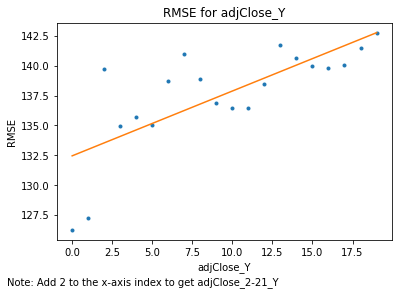

In [8]:
# Plot the RMSE for adjClose
x = np.arange(20)
y = rmse[0:20]

# Fit with polyfit
b, m = polyfit(x, y, 1)

# Add title and axis names
plt.title('RMSE for adjClose_Y')
plt.xlabel('adjClose_Y')
plt.ylabel('RMSE')

# Add a footnote below and to the left side of the chart
plt.figtext(0.01, -0.03,
            'Note: Add 2 to the x-axis index to get adjClose_2-21_Y',
            horizontalalignment='left')

plt.plot(x, y, '.')
plt.plot(x, m*x+b, '-')
plt.show()

In [9]:
# Evaluate MAE
mae = mean_absolute_error(y_test, ypred, multioutput='raw_values')

# For each value in rmse
for i in range(1, len(mae)+1):

    # Print the RMSE values for adjClose
    if i < 21:
        print("The MAE for adjClose_{}_Y = ".format(i+1), mae[i-1])

    # Print the RMSE values for min day
    elif 21 <= i < 25:
        print("The MAE for {}day_min = ".format((i-20)*5), mae[i-1])

    # Print the RMSE for max day
    else:
        print("The MAE for {}day_max = ".format((i-24)*5), mae[i-1])

The MAE for adjClose_2_Y =  46.83120348244304
The MAE for adjClose_3_Y =  46.76636219325692
The MAE for adjClose_4_Y =  52.30746031191313
The MAE for adjClose_5_Y =  51.12025950683488
The MAE for adjClose_6_Y =  49.92847877733334
The MAE for adjClose_7_Y =  50.888796357494414
The MAE for adjClose_8_Y =  53.130658791598044
The MAE for adjClose_9_Y =  56.68946339197532
The MAE for adjClose_10_Y =  52.4346566443341
The MAE for adjClose_11_Y =  51.469918701910615
The MAE for adjClose_12_Y =  51.673661495248474
The MAE for adjClose_13_Y =  51.049863717697484
The MAE for adjClose_14_Y =  51.2499498819763
The MAE for adjClose_15_Y =  52.96784878853295
The MAE for adjClose_16_Y =  51.604940335332145
The MAE for adjClose_17_Y =  51.02850502240236
The MAE for adjClose_18_Y =  50.13983199677684
The MAE for adjClose_19_Y =  51.2427947124598
The MAE for adjClose_20_Y =  52.39967504422171
The MAE for adjClose_21_Y =  52.72607210361295
The MAE for 5day_min =  1.3935280652961346
The MAE for 10day_min 

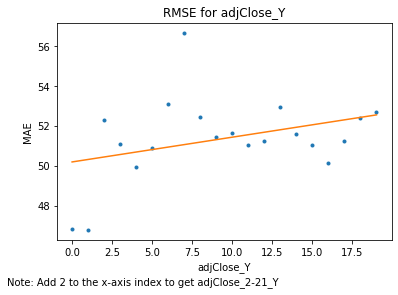

In [10]:
# Plot the MAE for adjClose
x = np.arange(20)
y = mae[0:20]

# Fit with polyfit
b, m = polyfit(x, y, 1)

# Add title and axis names
plt.title('RMSE for adjClose_Y')
plt.xlabel('adjClose_Y')
plt.ylabel('MAE')

# Add a footnote below and to the left side of the chart
plt.figtext(0.01, -0.03,
            'Note: Add 2 to the x-axis index to get adjClose_2-21_Y',
            horizontalalignment='left')

plt.plot(x, y, '.')
plt.plot(x, m*x+b, '-')
plt.show()